In [ ]:
# ===== IMPORTS Y CONFIGURACIÓN =====
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Configuración de visualización
plt.style.use('default') 
sns.set_theme(style="whitegrid") 
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


In [ ]:
# ===== FUNCIÓN DE PREPROCESAMIENTO =====

def preprocess_diabetes_data(df_raw, verbose=True):
    """
    Función de preprocesamiento para análisis de clustering de diabetes.
    
    Transformaciones aplicadas:
    - Síntomas: Yes=1, No=0
    - Género: Male=1, Female=0  
    - Edad: Normalización con StandardScaler
    - Separa variable objetivo
    
    Parámetros:
    -----------
    df_raw : pd.DataFrame
        Dataset crudo de diabetes
    verbose : bool
        Imprimir detalles de las transformaciones
        
    Retorna:
    --------
    tuple: (features_scaled, target, scaler)
    """
    
    df_clean = df_raw.copy()
    
    if verbose:
        print("Iniciando preprocesamiento...")
        print(f"Dimensiones originales: {df_raw.shape}")
    
    # Definir columnas de síntomas para codificación binaria
    symptom_cols = [
        'Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness', 
        'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching', 
        'Irritability', 'delayed healing', 'partial paresis', 
        'muscle stiffness', 'Alopecia', 'Obesity'
    ]
    
    # Codificación binaria para síntomas (Yes=1, No=0)
    for col in symptom_cols:
        df_clean[col] = df_clean[col].map({'Yes': 1, 'No': 0})
        
    # Codificación binaria para género (Male=1, Female=0)
    df_clean['Gender'] = df_clean['Gender'].map({'Male': 1, 'Female': 0})
    
    # Separar variable objetivo
    target = df_clean['class'].copy()
    features = df_clean.drop('class', axis=1)
    
    # Normalizar edad
    scaler = StandardScaler()
    features_scaled = features.copy()
    features_scaled['Age'] = scaler.fit_transform(features[['Age']])
    
    if verbose:
        print(f"Dimensiones finales: {features_scaled.shape}")
        print(f"Distribución género: Mujeres={sum(features_scaled['Gender']==0)}, Hombres={sum(features_scaled['Gender']==1)}")
        print(f"Distribución objetivo: {target.value_counts().to_dict()}")
        print("Preprocesamiento completado exitosamente.")
    
    return features_scaled, target, scaler


def validate_preprocessing(features_scaled, target):
    """
    Validación rápida de datos preprocesados.
    """
    print("\nResultados de validación:")
    print(f"- Dimensiones features: {features_scaled.shape}")
    print(f"- Dimensiones target: {target.shape}")
    print(f"- Valores faltantes: {features_scaled.isnull().sum().sum()}")
    print(f"- Rango de edad: [{features_scaled['Age'].min():.2f}, {features_scaled['Age'].max():.2f}]")
    
    # Verificar que variables binarias estén en rango [0,1]
    binary_cols = [col for col in features_scaled.columns if col != 'Age']
    non_binary = []
    for col in binary_cols:
        unique_vals = sorted(features_scaled[col].unique())
        if unique_vals != [0, 1]:
            non_binary.append(col)
    
    if non_binary:
        print(f"- Advertencia: Columnas no binarias encontradas: {non_binary}")
    else:
        print("- Todas las variables binarias validadas")


def save_processed_data(features_scaled, target, output_dir='../data/processed/'):
    """
    Guardar datos procesados en CSV.
    """
    import os
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Combinar features y target
    df_final = features_scaled.copy()
    df_final['class'] = target
    
    # Guardar en CSV
    output_path = os.path.join(output_dir, 'diabetes_clean.csv')
    df_final.to_csv(output_path, index=False)
    
    print(f"Datos procesados guardados en: {output_path}")
    return output_path

## Explicación de Función de Preprocesamiento de Datos para Análisis de Clustering

Preparación de los datos crudos para algoritmos de machine learning, a trvés de la transformación del dataset de diabetes para que todas las variables estén en escalas compatibles y formatos numéricos apropiados.

### 1. Codificación de Síntomas (Variables Categóricas → Binarias)

**Transformación:** `Yes = 1, No = 0`

```python
# Ejemplo de transformación
'Polyuria': ['Yes', 'No', 'Yes', 'No'] 
            ↓
'Polyuria': [1, 0, 1, 0]
```

### 2. Codificación de Género

**Transformación:** `Male = 1, Female = 0`

```python
'Gender': ['Male', 'Female', 'Male'] 
          ↓
'Gender': [1, 0, 1]
```

### 3. Normalización de Edad con StandardScaler

**Transformación:** `Edad_normalizada = (edad - media) / desviación_estándar`

```python
# Ejemplo del proceso
Edad original: [16, 25, 48, 65, 90]
Media: 48.8, Std: 12.1
Edad normalizada: [-2.71, -1.96, -0.07, 1.34, 3.40]
```

#### ¿Por qué normalizar la edad?
**Problema sin normalización:**
- **Edad:** rango 16-90 (diferencias de ~74 unidades)
- **Síntomas:** rango 0-1 (diferencias de 1 unidad)

En algoritmos de clustering que usan **distancia euclidiana** (como K-Means), las variables con mayor rango dominan el cálculo.

### 4. Separación de Variable Objetivo

**Transformación:** `class` se separa en variable independiente

```python
# Original: 17 columnas incluyendo 'class'
df_raw.shape = (520, 17)

# Después del preprocesamiento:
features_scaled.shape = (520, 16)  # Sin 'class'
target.shape = (520,)              # Solo 'class'
```

## Validación del Preprocesamiento

La función incluye validaciones para asegurar calidad de datos:

1. **Verificación de dimensiones:** Confirma que no se perdieron observaciones
2. **Validación de rangos:** Variables binarias en [0,1], edad normalizada centrada en 0
3. **Detección de valores faltantes:** Identifica NaNs que podrían causar errores
4. **Distribuciones finales:** Reporta balance de género y clases

## Resultado Final

**Dataset listo para clustering:**
- **16 variables numéricas** en escalas compatibles
- **520 observaciones** preservadas
- **Todas las variables contribuyen equitativamente** al algoritmo de clustering
- **Variable objetivo separada** para análisis post-clustering


In [3]:
# ===== CARGAR DATOS RAW =====

# Ruta base a los datos
diabetes_file_path = '../data/raw/diabetes_data_upload.csv'
df_raw = pd.read_csv(diabetes_file_path)  # CAMBIÉ: diabetes_df → df_raw

# Visión general del dataset
print("Dimensiones del dataset:", df_raw.shape)
print("\nPrimeras 5 filas:")
display(df_raw.head())

# Información sobre tipos de datos y valores no nulos
print("\nInformación del dataset:")
df_raw.info()

# Estadísticas descriptivas básicas
print("\nEstadísticas descriptivas:")
display(df_raw.describe(include='all').T)

# Verificación de valores faltantes
print("\nValores faltantes por columna:")
missing_values = df_raw.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No hay valores faltantes")

Dimensiones del dataset: (520, 17)

Primeras 5 filas:


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,520.0,NaN,NaN,NaN,48.028846,12.151466,16.0,39.0,47.5,57.0,90.0
Gender,520,2,Male,328,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Polyuria,520,2,No,262,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Polydipsia,520,2,No,287,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sudden weight loss,520,2,No,303,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weakness,520,2,Yes,305,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Polyphagia,520,2,No,283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Genital thrush,520,2,No,404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visual blurring,520,2,No,287,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Itching,520,2,No,267,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Valores faltantes por columna:
No hay valores faltantes


Distribución por género:
Gender
Male      328
Female    192
Name: count, dtype: int64


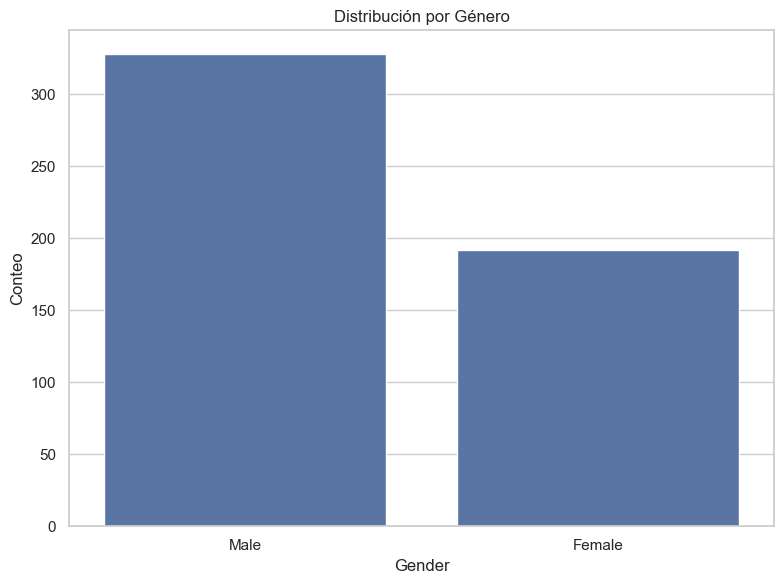

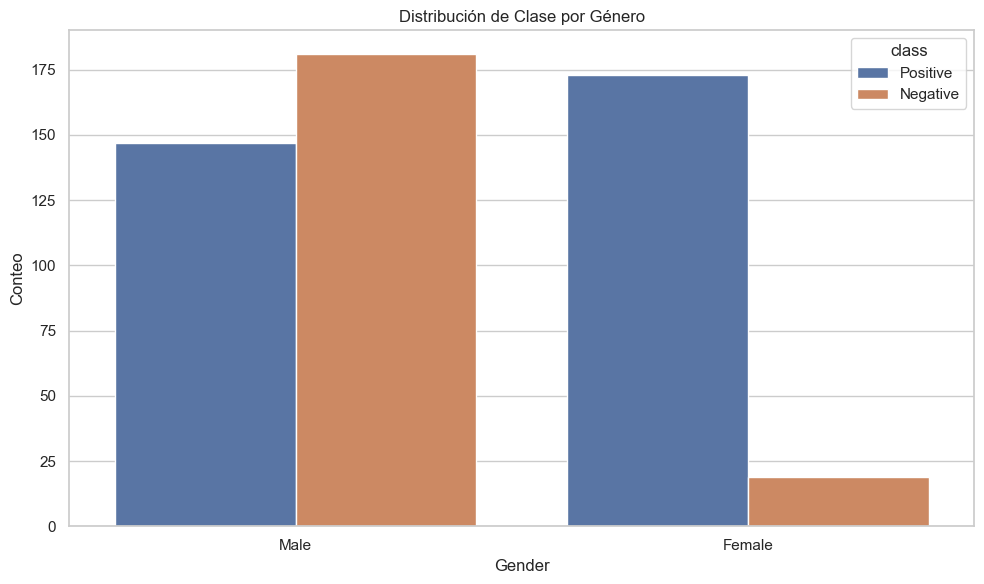

In [4]:
# ===== EDA INICIAL CON DATOS RAW =====

# Distribución de género en el dataset
gender_distribution = df_raw['Gender'].value_counts()  # CAMBIÉ: df → df_raw
print("Distribución por género:")
print(gender_distribution)

# Visualización de la distribución de género
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=df_raw)  # CAMBIÉ: df → df_raw
plt.title('Distribución por Género')
plt.ylabel('Conteo')
plt.tight_layout()
plt.show()

# Distribución de la clase objetivo por género
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='class', data=df_raw)  # CAMBIÉ: df → df_raw
plt.title('Distribución de Clase por Género')
plt.ylabel('Conteo')
plt.tight_layout()
plt.show()

In [5]:
# ===== APLICAR PREPROCESAMIENTO =====

# Aplicar preprocesamiento
features_scaled, target, scaler = preprocess_diabetes_data(df_raw, verbose=True)

# Validación de datos procesados
validate_preprocessing(features_scaled, target)

# Guardar datos procesados
save_processed_data(features_scaled, target)

Iniciando preprocesamiento...
Dimensiones originales: (520, 17)
Dimensiones finales: (520, 16)
Distribución género: Mujeres=192, Hombres=328
Distribución objetivo: {'Positive': 320, 'Negative': 200}
Preprocesamiento completado exitosamente.

Resultados de validación:
- Dimensiones features: (520, 16)
- Dimensiones target: (520,)
- Valores faltantes: 0
- Rango de edad: [-2.64, 3.46]
- Todas las variables binarias validadas
Datos procesados guardados en: ../data/processed/diabetes_clean.csv


'../data/processed/diabetes_clean.csv'

Primeras 5 filas de features procesados:


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
0,-0.661367,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1
1,0.821362,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0
2,-0.578993,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0
3,-0.249498,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0
4,0.986110,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1



Estadísticas descriptivas de features procesados:


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
count,5.200000e+02,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,5.807320e-17,0.630769,0.496154,0.448077,0.417308,0.586538,0.455769,0.223077,0.448077,0.486538,0.242308,0.459615,0.430769,0.375000,0.344231,0.169231
std,1.000963e+00,0.483061,0.500467,0.497776,0.493589,0.492928,0.498519,0.416710,0.497776,0.500300,0.428892,0.498846,0.495661,0.484589,0.475574,0.375317
min,-2.638339e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.437407e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-4.356309e-02,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.389884e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,3.457325e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


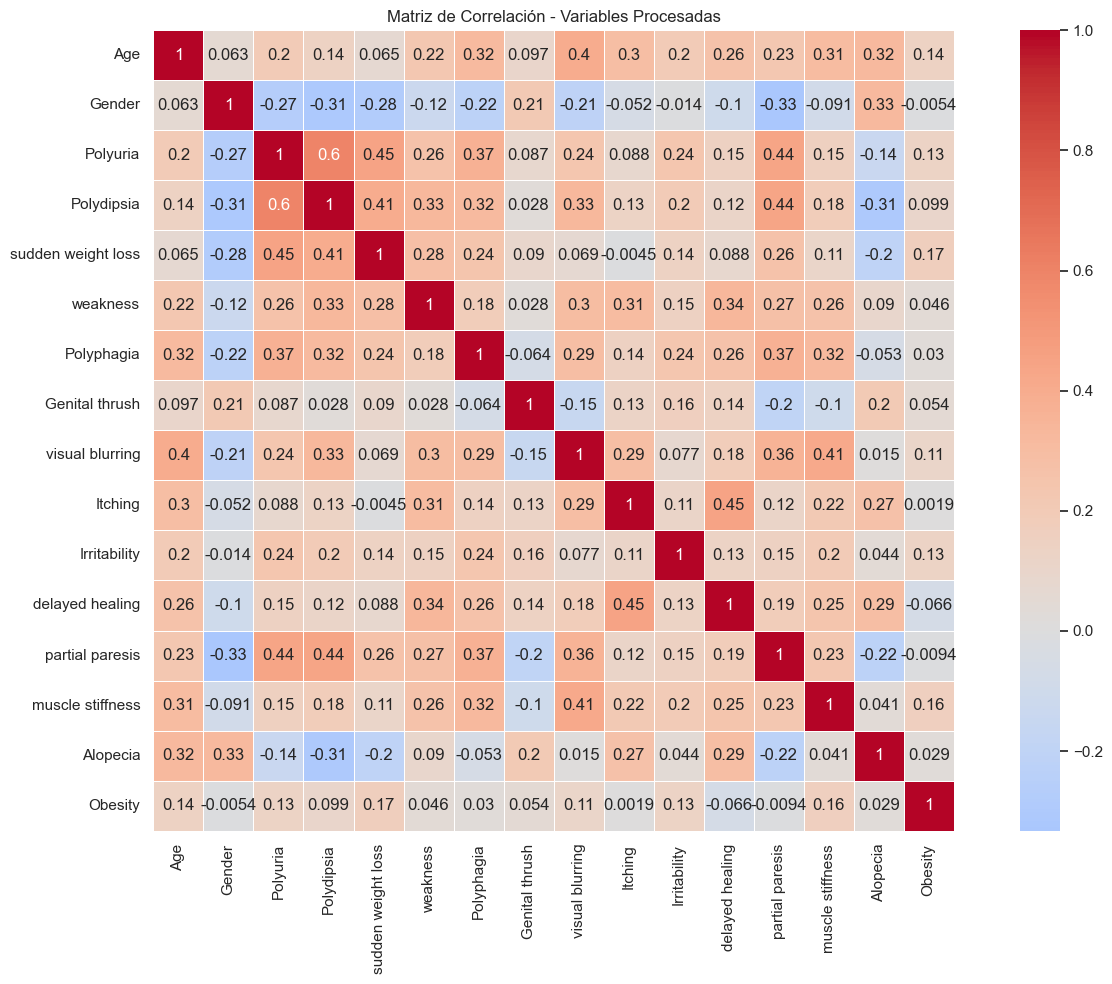

In [ ]:
# ===== EDA CON DATOS PROCESADOS I =====

# Mostrar primeras filas de datos procesados
print("Primeras 5 filas de features procesados:")
display(features_scaled.head())

# Estadísticas descriptivas de datos procesados
print("\nEstadísticas descriptivas de features procesados:")
display(features_scaled.describe())

# Correlación entre variables
plt.figure(figsize=(14, 10))
correlation_matrix = features_scaled.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Matriz de Correlación - Variables Procesadas')
plt.tight_layout()
plt.show()


Análisis de síntomas por género:
Género              Hombre  Mujer
Síntoma                          
Alopecia              46.3   14.1
Genital thrush        29.0   10.9
Irritability          23.8   25.0
Itching               46.6   52.1
Obesity               16.8   17.2
Polydipsia            32.9   65.1
Polyphagia            37.2   59.9
Polyuria              39.3   67.2
delayed healing       42.1   52.6
muscle stiffness      34.1   43.2
partial paresis       30.5   64.6
sudden weight loss    31.1   59.9
visual blurring       36.9   58.3
weakness              54.0   66.7


<Figure size 1200x800 with 0 Axes>

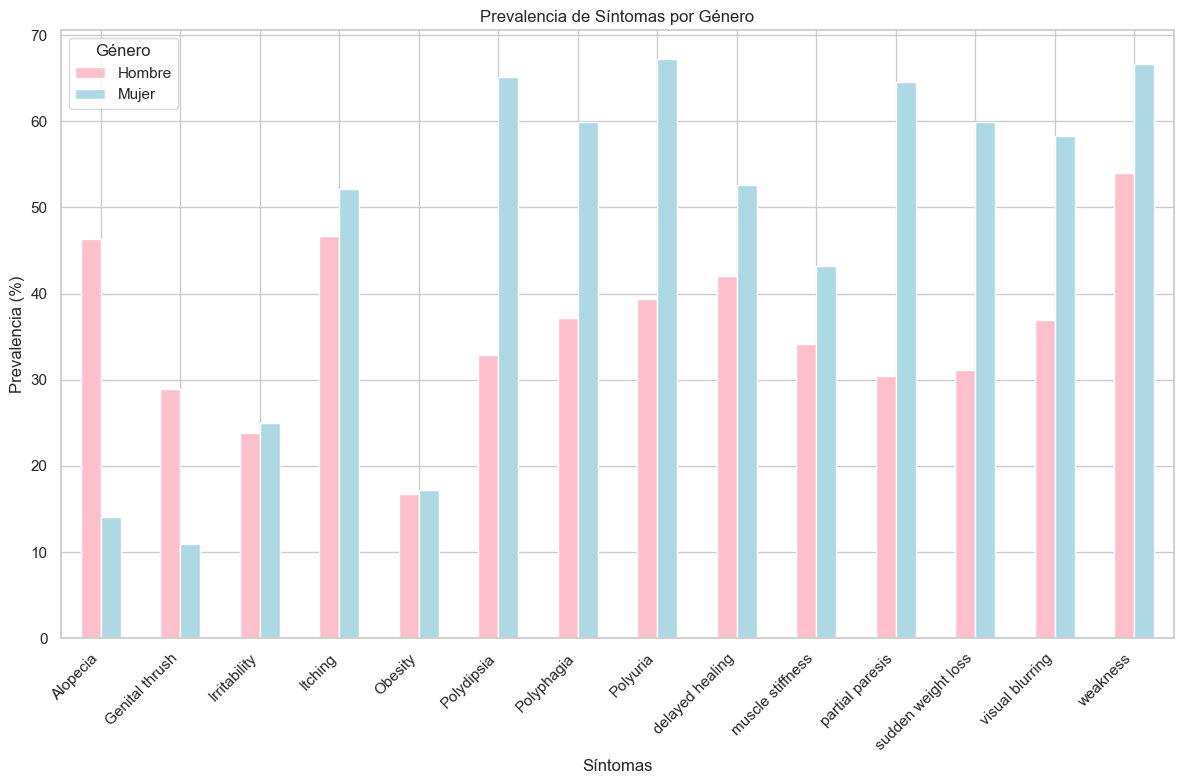

In [8]:
# ===== EDA CON DATOS PROCESADOS II =====

# Distribución de síntomas por género
print("\nAnálisis de síntomas por género:")
symptom_cols = [col for col in features_scaled.columns if col not in ['Age', 'Gender']]

# Crear dataframe para análisis por género
df_analysis = features_scaled.copy()
df_analysis['Gender_label'] = df_analysis['Gender'].map({0: 'Mujer', 1: 'Hombre'})

# Calcular prevalencia de síntomas por género
prevalence_by_gender = []
for symptom in symptom_cols:
    for gender_val, gender_label in [(0, 'Mujer'), (1, 'Hombre')]:
        mask = df_analysis['Gender'] == gender_val
        prevalence = df_analysis.loc[mask, symptom].mean() * 100
        prevalence_by_gender.append({
            'Síntoma': symptom,
            'Género': gender_label,
            'Prevalencia (%)': prevalence
        })

prevalence_df = pd.DataFrame(prevalence_by_gender)
pivot_prevalence = prevalence_df.pivot(index='Síntoma', columns='Género', values='Prevalencia (%)')

print(pivot_prevalence.round(1))

# Visualización de prevalencia por género
plt.figure(figsize=(12, 8))
pivot_prevalence.plot(kind='bar', color=['pink', 'lightblue'])
plt.title('Prevalencia de Síntomas por Género')
plt.xlabel('Síntomas')
plt.ylabel('Prevalencia (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Género')
plt.tight_layout()
plt.show()

